In [44]:
!pip install xgboost
import pandas as pd
import numpy as np
import xgboost as xgb
import re
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import string
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from textblob import TextBlob
from nsetools import Nse
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import joblib
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import gensim
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



**Read The Dataset**

In [4]:
df=pd.read_csv('2025_timestamps.csv')

**data set**

In [5]:
df

,Unnamed: 0,id,Date,Headline,Link,Last_Updated
0,0,2222275,2025-01-30,US Federal Reserve leaves key lending rate unc...,/business/international-business/us-federal-re...,2025-01-30 01:17:00
1,1,2222382,2025-01-30,How finance minister can simplify tax regime f...,/business/india-business/how-finance-minister-...,2025-01-30 05:48:00
2,2,2222383,2025-01-30,Government looks to position India as manpower...,/business/india-business/government-looks-to-p...,2025-01-30 05:44:00
3,3,2222384,2025-01-30,"Drive workforce growth, talent mobility: Experts",/business/india-business/drive-workforce-growt...,2025-01-30 05:36:00
4,4,2221649,2025-01-29,New Samsung union in Chennai to hold talks on ...,/business/india-business/new-samsung-union-to-...,2025-01-29 10:23:00
...,...,...,...,...,...,...
47939,47939,368023,2015-01-01,Maruti's December sales jump 20.8 pc; shares up,http://timesofindia.indiatimes.com//business/i...,2015-01-01 12:19:00
47940,47940,368056,2015-01-01,India Inc promises 10 lakh new jobs in 2015,http://timesofindia.indiatimes.com//business/i...,2015-01-01 13:08:00
47941,47941,368149,2015-01-01,Afghan pharma firms to seek JVs at Vibrant Guj...,http://timesofindia.indiatimes.com//business/i...,2015-01-01 15:27:00
47942,47942,368153,2015-01-01,General Motors' sales decline 36.56% in Dec,http://timesofindia.indiatimes.com//business/i...,2015-01-01 15:34:00


**Shape of The Dataset**

In [6]:
df.shape

(47944, 6)


# **Data Preprocessing**

**Checking Null Values**

In [7]:
df.isnull().sum()

Unnamed: 0        0
id                0
Date              0
Headline          0
Link              0
Last_Updated    136
dtype: int64

In [8]:
df = df.dropna(subset=['Last_Updated'])
df.isnull().sum()


Unnamed: 0      0
id              0
Date            0
Headline        0
Link            0
Last_Updated    0
dtype: int64

**Shape and column info**

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47808 entries, 0 to 47943
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    47808 non-null  int64 
 1   id            47808 non-null  int64 
 2   Date          47808 non-null  object
 3   Headline      47808 non-null  object
 4   Link          47808 non-null  object
 5   Last_Updated  47808 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.6+ MB


In [10]:
df.describe()

,Unnamed: 0,id
count,47808.000000,4.780800e+04
mean,23933.541960,1.224757e+06
std,13819.787655,5.245409e+05
min,0.000000,3.678710e+05
25%,11972.750000,7.831112e+05
50%,23926.500000,1.162888e+06
75%,35891.250000,1.688844e+06
max,47943.000000,2.222384e+06


**Drop unnecessary columns**

In [11]:
df.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)


**Convert date columns to datetime**

In [12]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Last_Updated'] = pd.to_datetime(df['Last_Updated'], errors='coerce')

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd

# Load Pre-trained Financial Sentiment Model
tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

# Function to Predict Sentiment for a Single Headline
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    sentiment_labels = ["Negative", "Neutral", "Positive"]
    return sentiment_labels[predicted_class]

# Example DataFrame (If not already loaded)
# df = pd.read_csv("your_file.csv")  # Load your dataset if needed

# Apply Sentiment Analysis to Each Headline
df["Sentiment"] = df["Headline"].apply(predict_sentiment)

# Display Results
print(df.head())

        Date                                           Headline  \
0 2025-01-30  US Federal Reserve leaves key lending rate unc...   
1 2025-01-30  How finance minister can simplify tax regime f...   
2 2025-01-30  Government looks to position India as manpower...   
3 2025-01-30   Drive workforce growth, talent mobility: Experts   
4 2025-01-29  New Samsung union in Chennai to hold talks on ...   

                                                Link        Last_Updated  \
0  /business/international-business/us-federal-re... 2025-01-30 01:17:00   
1  /business/india-business/how-finance-minister-... 2025-01-30 05:48:00   
2  /business/india-business/government-looks-to-p... 2025-01-30 05:44:00   
3  /business/india-business/drive-workforce-growt... 2025-01-30 05:36:00   
4  /business/india-business/new-samsung-union-to-... 2025-01-29 10:23:00   

  Sentiment  
0   Neutral  
1  Positive  
2  Positive  
3  Positive  
4   Neutral  


**Labelling Products Based On Ratings Given**

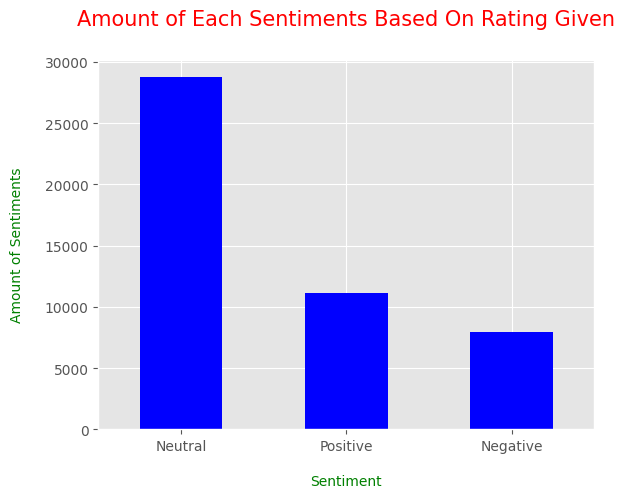

In [14]:
df["Sentiment"].value_counts().plot(kind = "bar", color = "blue")
plt.title("Amount of Each Sentiments Based On Rating Given", loc = "center", fontsize = 15, color = "red", pad = 25)
plt.xlabel("Sentiment", color = "green", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Amount of Sentiments", color = "green", fontsize = 10, labelpad = 15)
plt.show()

## Time-based Analysis

**Articles per day**

<Axes: title={'center': 'Articles Per Day'}, xlabel='Date'>

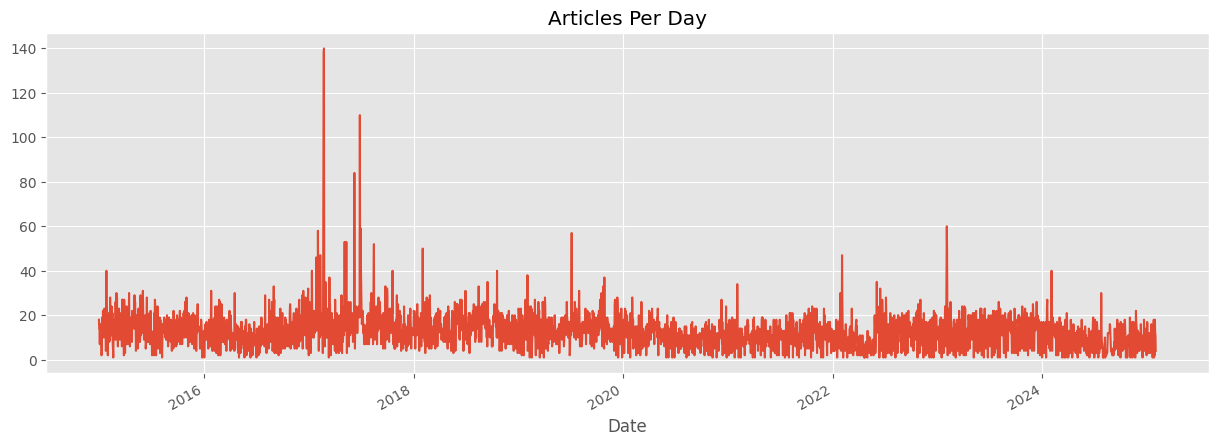

In [15]:
daily_counts = df['Date'].value_counts().sort_index()
daily_counts.plot(figsize=(15,5), title="Articles Per Day")

**Word Frequency / WordCloud**

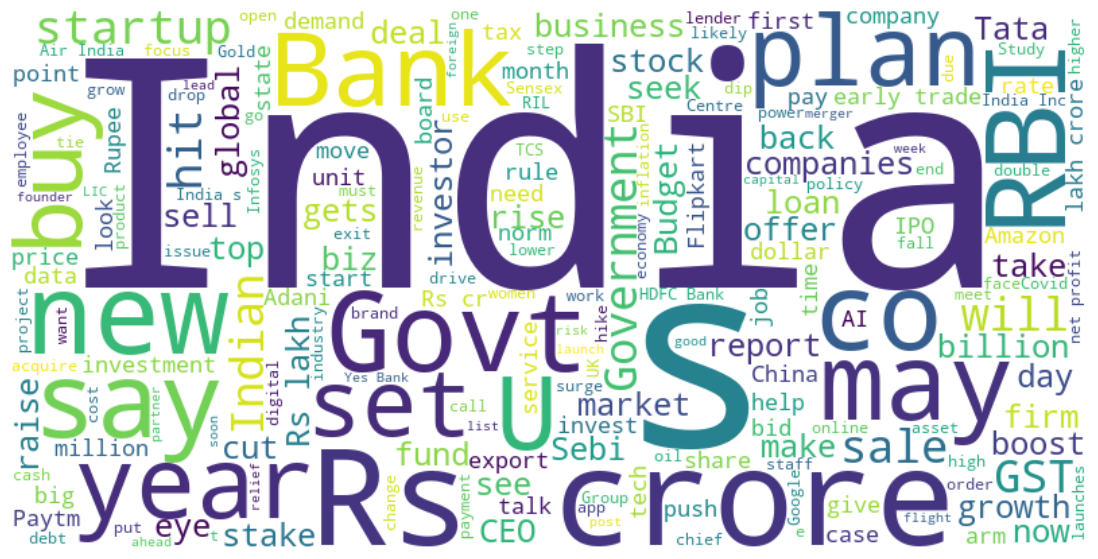

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = " ".join(df['Headline'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Sentiment Distribution**

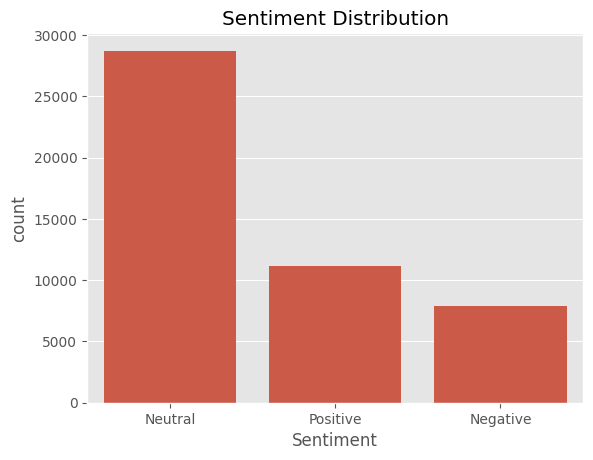

In [17]:
sns.countplot(data=df, x='Sentiment', order=df['Sentiment'].value_counts().index)
plt.title("Sentiment Distribution")
plt.show()

**Sentiment Over Time**

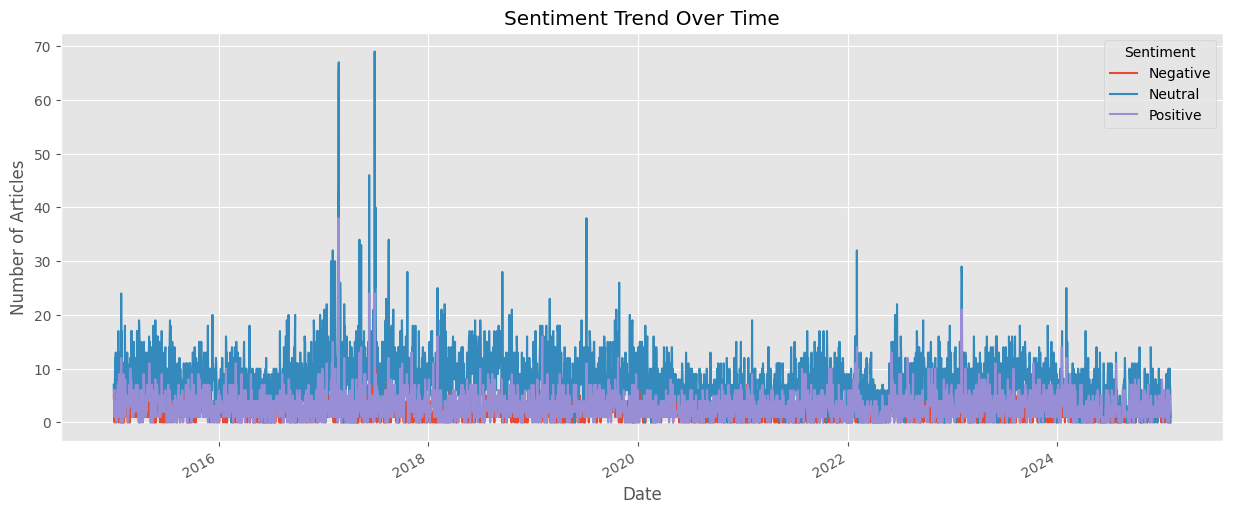

In [18]:
sentiment_by_date = df.groupby(['Date', 'Sentiment']).size().unstack().fillna(0)
sentiment_by_date.plot(figsize=(15,6), title="Sentiment Trend Over Time")
plt.ylabel("Number of Articles")
plt.show()

**Headline Length per Sentiment**

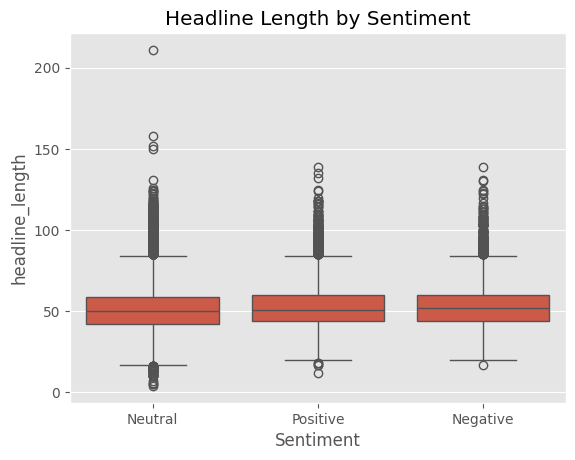

In [19]:
df['headline_length'] = df['Headline'].apply(len)

sns.boxplot(data=df, x='Sentiment', y='headline_length')
plt.title("Headline Length by Sentiment")
plt.show()

**Common Words by Sentiment**

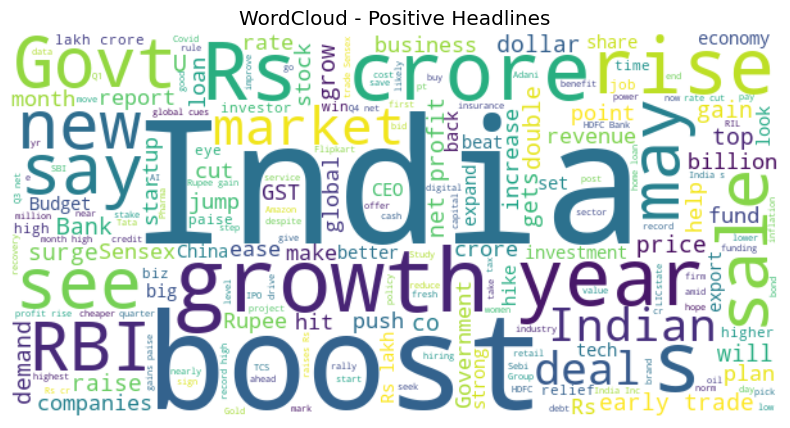

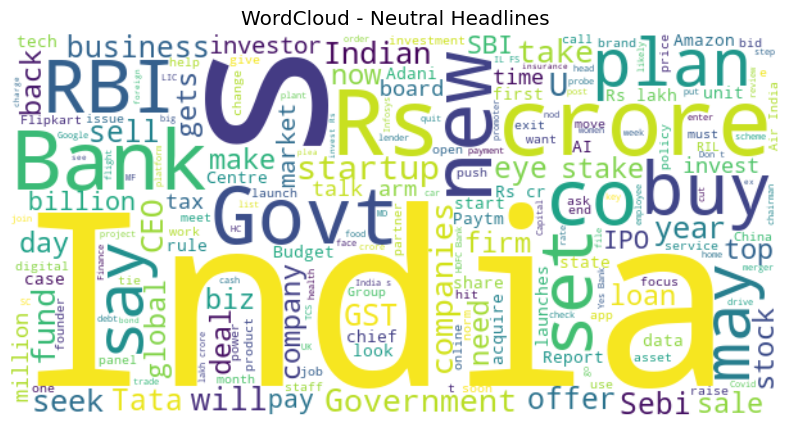

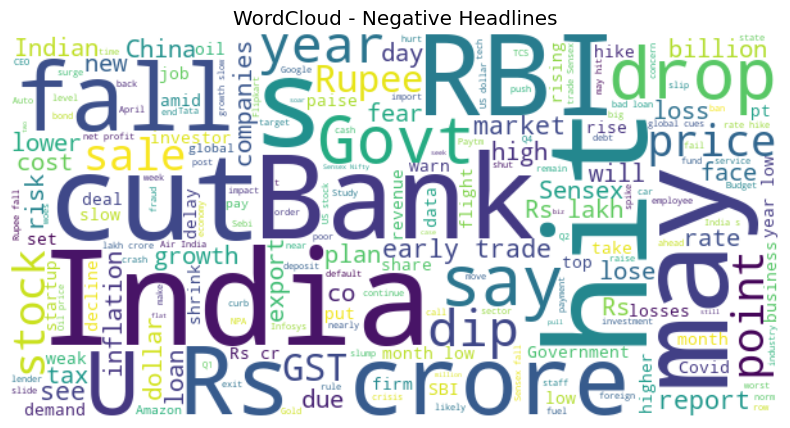

In [20]:
for sentiment in ['Positive', 'Neutral', 'Negative']:
    text = " ".join(df[df['Sentiment'] == sentiment]['Headline'])
    wc = WordCloud(width=600, height=300, background_color='white').generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - {sentiment.capitalize()} Headlines")
    plt.show()

## Most Common Words (TF)

In [21]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english') + list(string.punctuation))

def get_top_words(sentiment, n=20):
    text = " ".join(df[df['Sentiment'] == sentiment]['Headline']).lower()
    tokens = [word for word in text.split() if word not in stop_words]
    return Counter(tokens).most_common(n)

for sentiment in ['positive', 'neutral', 'negative']:
    top_words = get_top_words(sentiment)
    print(f"\nTop words in {sentiment} headlines:")
    for word, freq in top_words:
        print(f"{word}: {freq}")


Top words in positive headlines:

Top words in neutral headlines:

Top words in negative headlines:


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Most Frequent Bigrams and Trigrams by Sentiment**

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(sentiment, ngram_range=(2, 2), top_n=10):
    text_data = df[df['Sentiment'] == sentiment]['Headline'].dropna()
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range).fit(text_data)
    bag_of_words = vec.transform(text_data)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]

for sentiment in ['Positive', 'Neutral', 'Negative']:
    print(f"\n🔸 Top Bigrams in {sentiment.capitalize()} Headlines")
    print("-" * 40)
    for phrase, freq in get_top_ngrams(sentiment, (2, 2)):
        print(f"{phrase:<30} {freq}")
    
    print(f"\n🔸 Top Trigrams in {sentiment.capitalize()} Headlines")
    print("-" * 40)
    for phrase, freq in get_top_ngrams(sentiment, (3, 3)):
        print(f"{phrase:<30} {freq}")


🔸 Top Bigrams in Positive Headlines
----------------------------------------
early trade                    238
paise dollar                   193
net profit                     178
dollar early                   128
lakh crore                     104
profit rises                   100
000 crore                      100
global cues                    83
month high                     80
rupee gains                    80

🔸 Top Trigrams in Positive Headlines
----------------------------------------
dollar early trade             127
paise dollar early             114
net profit rises               69
rs lakh crore                  53
points early trade             51
gains paise dollar             41
rupee gains paise              35
rs 000 crore                   32
bank net profit                26
q4 net profit                  24

🔸 Top Bigrams in Neutral Headlines
----------------------------------------
000 crore                      323
air india                      185
rs 000 

Positive: Growth-oriented and profit-driven language.

Neutral: Report-focused, institutional or announcement-heavy.

Negative: Language around drops, weak performance, or losses.

**Top TF-IDF Words by Sentiment (Important & Unique)**

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_top_tfidf_words(sentiment, top_n=15):
    text_data = df[df['Sentiment'] == sentiment]['Headline'].dropna()
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(text_data)
    avg_tfidf = X.mean(axis=0).A1
    tfidf_scores = dict(zip(vectorizer.get_feature_names_out(), avg_tfidf))
    return sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

for sentiment in ['Positive', 'Neutral', 'Negative']:
    print(f"\n🟢 Top TF-IDF Words for {sentiment.capitalize()} Sentiment")
    print("=" * 45)
    for word, score in get_top_tfidf_words(sentiment):
        print(f"{word:<20} {score:.4f}")



🟢 Top TF-IDF Words for Positive Sentiment
india                0.0289
rs                   0.0249
growth               0.0188
sensex               0.0188
crore                0.0167
boost                0.0151
bank                 0.0135
net                  0.0129
profit               0.0127
high                 0.0116
new                  0.0116
rbi                  0.0114
rupee                0.0114
trade                0.0113
sales                0.0113

🟢 Top TF-IDF Words for Neutral Sentiment
india                0.0277
rs                   0.0240
crore                0.0156
bank                 0.0150
rbi                  0.0147
govt                 0.0129
new                  0.0129
gst                  0.0104
tax                  0.0095
companies            0.0094
banks                0.0090
tata                 0.0089
sebi                 0.0089
says                 0.0087
ceo                  0.0087

🟢 Top TF-IDF Words for Negative Sentiment
rs                   0.0227
indi

Positive Sentiment:Optimism, financial gains, and strong performance.

Neutral Sentiment: Informative, factual, and non-emotional content.

Negative Sentiment: Caution, market volatility, or bad financial events.


## Text Preprocessing

**Text Cleaning**

In [24]:
# 📦 Download required NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# 🔧 Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# 🧼 Preprocessing Function
def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove URLs
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    
    # 3. Remove mentions (@username) and hashtags (#)
    text = re.sub(r"@\w+|#", "", text)
    
    # 4. Remove punctuation/special characters
    text = re.sub(r"[^\w\s]", "", text)
    
    # 5. Remove numbers
    text = re.sub(r"\d+", "", text)
    
    # 6. Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    
    # 7. Tokenize
    words = word_tokenize(text)
    
    # 8. Lemmatize
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # 9. Return cleaned text
    return " ".join(words)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [25]:
# Convert list of headlines to a single string before applying data_processing
df['text'] = df['Headline'].apply(preprocess_text)


In [26]:
df

,Date,Headline,Link,Last_Updated,Sentiment,headline_length,text
0,2025-01-30,US Federal Reserve leaves key lending rate unc...,/business/international-business/us-federal-re...,2025-01-30 01:17:00,Neutral,95,u federal reserve leaf key lending rate unchan...
1,2025-01-30,How finance minister can simplify tax regime f...,/business/india-business/how-finance-minister-...,2025-01-30 05:48:00,Positive,60,how finance minister can simplify tax regime f...
2,2025-01-30,Government looks to position India as manpower...,/business/india-business/government-looks-to-p...,2025-01-30 05:44:00,Positive,64,government look to position india a manpower s...
3,2025-01-30,"Drive workforce growth, talent mobility: Experts",/business/india-business/drive-workforce-growt...,2025-01-30 05:36:00,Positive,48,drive workforce growth talent mobility expert
4,2025-01-29,New Samsung union in Chennai to hold talks on ...,/business/india-business/new-samsung-union-to-...,2025-01-29 10:23:00,Neutral,70,new samsung union in chennai to hold talk on w...
...,...,...,...,...,...,...,...
47939,2015-01-01,Maruti's December sales jump 20.8 pc; shares up,http://timesofindia.indiatimes.com//business/i...,2015-01-01 12:19:00,Positive,47,marutis december sale jump pc share up
47940,2015-01-01,India Inc promises 10 lakh new jobs in 2015,http://timesofindia.indiatimes.com//business/i...,2015-01-01 13:08:00,Positive,43,india inc promise lakh new job in
47941,2015-01-01,Afghan pharma firms to seek JVs at Vibrant Guj...,http://timesofindia.indiatimes.com//business/i...,2015-01-01 15:27:00,Neutral,50,afghan pharma firm to seek jv at vibrant gujarat
47942,2015-01-01,General Motors' sales decline 36.56% in Dec,http://timesofindia.indiatimes.com//business/i...,2015-01-01 15:34:00,Negative,43,general motor sale decline in dec


In [28]:
sentences = df['text']

# Tokenize words
tokenized_sentences = [sentence.lower().split() for sentence in sentences]

# Train Word2Vec model (creates 100-dim word vectors)
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Convert words to vectors
def sentence_to_vector(sentence, model, vector_size=100):
    words = sentence.lower().split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

In [45]:
X = np.array([sentence_to_vector(sentence, word2vec_model) for sentence in sentences])
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(df['Sentiment'])
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# **Model**

# Logistic regration

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
logreg = LogisticRegression()
from sklearn.model_selection import GridSearchCV

logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 70.36%


In [32]:
param_grid = [
    {'penalty':['l1','l2','elasticnet','none'],
    'C' : np.logspace(-4,4,20),
    'solver': ['lbfgs','newton-cg','liblinear','saga'],
    'max_iter'  : [100,1000]
}
]

clf = GridSearchCV(logreg,param_grid = param_grid, cv = 3, verbose=True,n_jobs=-1)
clf

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'max_iter': [100, 1000],
                          'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                          'solver': ['lbfgs', 'newton-cg', 'liblinear',
                                     'saga']}],
             verbose=True)

In [33]:
logreg_model = LogisticRegression(C=0.615848211066026, max_iter=1000, penalty='l1',solver='liblinear')
logreg_model.fit(x_train, y_train)
logreg_model_pred = logreg_model.predict(x_test)
logreg_acc = accuracy_score(logreg_model_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 71.22%


# SVM

In [34]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

In [35]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)
SVCmodel_pred = SVCmodel.predict(x_test)
SVCmodel_acc = accuracy_score(SVCmodel_pred, y_test)
print("Test accuracy: {:.2f}%".format(SVCmodel_acc*100))

Test accuracy: 71.76%


In [37]:
param_grid = {'penalty':['l1', 'l2'] ,
    'loss':['squared_hinge', 'hinge'] ,
    
    'C': np.logspace(1,2,3),
    'multi_class':['ovr', 'crammer_singer'] ,
     }  
  
SVc_grid = GridSearchCV(LinearSVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
SVc_grid.fit(x_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END C=10.0, loss=squared_hinge, multi_class=ovr, penalty=l1;, score=0.703 total time=  29.4s
[CV 2/5] END C=10.0, loss=squared_hinge, multi_class=ovr, penalty=l1;, score=0.701 total time=  29.0s
[CV 3/5] END C=10.0, loss=squared_hinge, multi_class=ovr, penalty=l1;, score=0.699 total time=  29.0s
[CV 4/5] END C=10.0, loss=squared_hinge, multi_class=ovr, penalty=l1;, score=0.702 total time=  30.3s
[CV 5/5] END C=10.0, loss=squared_hinge, multi_class=ovr, penalty=l1;, score=0.702 total time=  30.8s
[CV 1/5] END C=10.0, loss=squared_hinge, multi_class=ovr, penalty=l2;, score=0.714 total time=  18.5s
[CV 2/5] END C=10.0, loss=squared_hinge, multi_class=ovr, penalty=l2;, score=0.714 total time=  17.6s
[CV 3/5] END C=10.0, loss=squared_hinge, multi_class=ovr, penalty=l2;, score=0.716 total time=  15.8s
[CV 4/5] END C=10.0, loss=squared_hinge, multi_class=ovr, penalty=l2;, score=0.713 total time=  16.9s
[CV 5/5] END C=10.0,

GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': array([ 10.       ,  31.6227766, 100.       ]),
                         'loss': ['squared_hinge', 'hinge'],
                         'multi_class': ['ovr', 'crammer_singer'],
                         'penalty': ['l1', 'l2']},
             verbose=3)

In [39]:
SVc_grid

GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': array([ 10.       ,  31.6227766, 100.       ]),
                         'loss': ['squared_hinge', 'hinge'],
                         'multi_class': ['ovr', 'crammer_singer'],
                         'penalty': ['l1', 'l2']},
             verbose=3)

In [38]:
SVc_grid_model_pred = SVc_grid.predict(x_test)
SVc_grid_acc = accuracy_score(SVc_grid_model_pred, y_test)
print("Test accuracy: {:.2f}%".format(SVc_grid_acc*100))

Test accuracy: 72.40%


#  XGBoost for Classification


In [46]:

# XGBoost for multi-class
model = xgb.XGBClassifier(
    objective='multi:softmax',       # Softmax for multi-class classification
    num_class=3,                     # Number of classes: 3 in this case
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# Train the model
model.fit(x_train, y_train)

# Predict
y_pred = model.predict(x_test)

# Decode predicted labels back to original strings
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

# Evaluation
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))

Accuracy: 0.7166910688140556
Classification Report:
               precision    recall  f1-score   support

    Negative       0.57      0.31      0.41      1568
     Neutral       0.75      0.95      0.84      5777
    Positive       0.64      0.40      0.49      2217

    accuracy                           0.72      9562
   macro avg       0.65      0.55      0.58      9562
weighted avg       0.69      0.72      0.69      9562



# Random Forest

In [47]:
# Initialize and train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)
rf_model.fit(x_train, y_train)

# Predict
y_pred = rf_model.predict(x_test)

# Decode predicted labels back to original
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))

Accuracy: 0.72599874503242
Classification Report:
               precision    recall  f1-score   support

    Negative       0.62      0.32      0.42      1568
     Neutral       0.75      0.95      0.84      5777
    Positive       0.65      0.43      0.52      2217

    accuracy                           0.73      9562
   macro avg       0.68      0.57      0.59      9562
weighted avg       0.71      0.73      0.70      9562



# Text Classifier using Word2Vec Embeddings

In [ ]:
import numpy as np
import gensim
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Sample text data (replace with your dataset)
sentences = df['Headline']
df['labels'] = df['Sentiment'].replace({'Positive': 2,'Neutral':1, 'Negative': 0})
# Tokenize words
tokenized_sentences = [sentence.lower().split() for sentence in sentences]

# Train Word2Vec model (creates 100-dim word vectors)
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

MAX_LEN = 20
EMBEDDING_DIM = 100

def sentence_to_sequence(sentence, model, max_len=MAX_LEN):
    words = sentence.lower().split()
    vectors = [model.wv[word] if word in model.wv else np.zeros(EMBEDDING_DIM) for word in words]
    vectors = vectors[:max_len]
    while len(vectors) < max_len:
        vectors.append(np.zeros(EMBEDDING_DIM))  # pad with zeros
    return np.array(vectors)

X = np.array([sentence_to_sequence(sent, word2vec_model) for sent in sentences])
y = df['labels'] 
y = np.array(y)  # Convert (-1, 0, 1) → (0, 1, 2)
   # Example labels (1 = positive, 0 = negative)
   # Reshape input for LSTM (samples, timesteps, features)
y = to_categorical(y, num_classes=3)
X = X.reshape((X.shape[0], 1, X.shape[1])) 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, BatchNormalization, Bidirectional
# Build LSTM Model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=False, input_shape=(X.shape[1], X.shape[2]))),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),  # Corrected
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(3, activation='softmax')  # Softmax for multi-class classification
])
# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model
model.fit(x_train, y_train, epochs=50, batch_size=2, verbose=1, validation_data=(x_test, y_test))


Epoch 1/50


ValueError: Input 0 of layer "bidirectional" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (2, 100)

In [ ]:
model.summary()


In [ ]:
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(classification_report(y_true_labels, y_pred_labels))